In [1]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)

import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import binned_statistic

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Model accuracy

In [2]:
data_indices = [0,1,2,3,4]
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['Finetuned BERT', 'Finetuned S-BERT', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

In [3]:
def get_accuracy(y,y_hat):
    is_same = (y==y_hat)
    acc = sum(is_same)/len(is_same)
    return acc

def get_f1_score(y, y_hat):
    return f1_score(y, y_hat, average='macro')

In [4]:
model2acc = {}
model2f1macro = {}

for model_type in model_types:    
    model2acc[model_type] = []
    model2f1macro[model_type] = []
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        y = df_sample['true_outcome']
        y_hat = df_sample['predicted_outcome']
        model2acc[model_type].append(get_accuracy(y, y_hat))
        model2f1macro[model_type].append(get_f1_score(y, y_hat))
        
    print("%22s Acc:%.2f%% (std: %.2f)"%(model_type, np.average(model2acc[model_type])*100, np.std(model2acc[model_type])*100))
    print("%22s  F1:%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro[model_type])*100, np.std(model2f1macro[model_type])*100))
    print()

         model_bert_ft Acc:56.33% (std: 0.71)
         model_bert_ft  F1:56.17% (std: 0.70)

 model_roberta-base_ft Acc:57.66% (std: 1.18)
 model_roberta-base_ft  F1:57.57% (std: 1.16)

            model_bert Acc:53.89% (std: 0.51)
            model_bert  F1:49.10% (std: 1.68)

    model_roberta-base Acc:56.14% (std: 0.50)
    model_roberta-base  F1:51.97% (std: 0.64)



In [5]:
df_sample.head()

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred
63730,The-Democratic-Peoples-Republic-of-Korea-is-no...,The Democratic People's Republic of Korea is n...,SteveMaxwell,2015-10-25,Pro,1.0,I agree with the following: The Democratic Peo...,1,True,True,24.716259,24.834814,24.775536,0.004797,True,0
63731,The-democrats-are-more-racist-than-the-republi...,The democrats are more racist than the republi...,Flipbook,2014-11-24,Pro,1.0,I agree with the following: The democrats are ...,8,False,True,16.578342,18.275551,17.426947,0.102375,False,1
63732,The-Democrats-are-not-protecting-the-US-Consti...,The Democrats are not protecting the US Consti...,Flipbook,2013-05-14,Pro,1.0,I agree with the following: The Democrats are ...,8,False,True,16.456379,17.252188,16.854282,0.048359,False,0
63733,The-Democrats-scare-me./1/,The Democrats scare me.,wingnut2280,2008-01-22,Pro,1.0,I agree with the following: The Democrats scar...,42,False,True,13.721004,15.272534,14.496769,0.113077,False,1
63734,The-democrats-show-their-true-colors-stalinist...,The democrats show their true colors - stalini...,Solarman1969,2008-02-15,Pro,1.0,I agree with the following: The democrats show...,55,True,True,15.502457,16.059826,15.781141,0.035954,True,1


## Baseline accuracy

In [5]:
#사실 baseline은 모델별로 의미가 없어서 한 데이터만 사용해도 됨. 
model2acc_majority = {}
model2f1macro_majority = {}
model2acc_rand = {}
model2f1macro_rand = {}

for model_type in model_types[2:3]: #model does not effect to random basline, so just pick one model to extract the results.     
    model2acc_majority[model_type] = []
    model2f1macro_majority[model_type] = []
    model2acc_rand[model_type] = []
    model2f1macro_rand[model_type] = []
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))

        y = df_sample['true_outcome']
        y_hat_maj = df_sample['majority_pred_group']
        y_hat_rand = df_sample['random_pred']
        
        model2acc_majority[model_type].append(get_accuracy(y, y_hat_maj))
        model2f1macro_majority[model_type].append(get_f1_score(y, y_hat_maj))
        model2acc_rand[model_type].append(get_accuracy(y, y_hat_rand))
        model2f1macro_rand[model_type].append(get_f1_score(y, y_hat_rand))
        
    print("%22s Acc(majority):%.2f%% (std: %.2f)"%(model_type, np.average(model2acc_majority[model_type])*100, np.std(model2acc_majority[model_type])*100))
    print("%22s  F1(majority):%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro_majority[model_type])*100, np.std(model2f1macro_majority[model_type])*100))    
    print("%22s Acc(random):%.2f%% (std: %.2f)"%(model_type, np.average(model2acc_rand[model_type])*100, np.std(model2acc_rand[model_type])*100))
    print("%22s  F1(random):%.2f%% (std: %.2f)"%(model_type, np.average(model2f1macro_rand[model_type])*100, np.std(model2f1macro_rand[model_type])*100))        
    print()
    

            model_bert Acc(majority):53.24% (std: 0.29)
            model_bert  F1(majority):34.74% (std: 0.12)
            model_bert Acc(random):49.98% (std: 0.18)
            model_bert  F1(random):49.93% (std: 0.18)



In [7]:
df_sample.head()

,debate_key,debate_title,username,debate_date,position,is_belief,belief_statement,votelen,predicted_outcome,true_outcome,d_min,d_max,d_avg,d_rel,majority_pred,random_pred
63730,The-Democratic-Peoples-Republic-of-Korea-is-no...,The Democratic People's Republic of Korea is n...,SteveMaxwell,2015-10-25,Pro,1.0,I agree with the following: The Democratic Peo...,1,False,True,7.910920,8.036761,7.973841,0.015907,True,0
63731,The-democrats-are-more-racist-than-the-republi...,The democrats are more racist than the republi...,Flipbook,2014-11-24,Pro,1.0,I agree with the following: The democrats are ...,8,True,True,4.173783,4.175610,4.174696,0.000438,False,0
63732,The-Democrats-are-not-protecting-the-US-Consti...,The Democrats are not protecting the US Consti...,Flipbook,2013-05-14,Pro,1.0,I agree with the following: The Democrats are ...,8,True,True,3.728162,3.821721,3.774942,0.025095,False,0
63733,The-Democrats-scare-me./1/,The Democrats scare me.,wingnut2280,2008-01-22,Pro,1.0,I agree with the following: The Democrats scar...,42,False,True,3.817643,3.893041,3.855342,0.019750,False,1
63734,The-democrats-show-their-true-colors-stalinist...,The democrats show their true colors - stalini...,Solarman1969,2008-02-15,Pro,1.0,I agree with the following: The democrats show...,55,False,True,4.902492,4.911833,4.907163,0.001906,True,1


## User history vs F1-score

In [37]:
model2mat_f1 = {}

for model_type in model_types: 
        
    print(model_type)
    
    L = 1000
    mat_f1  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        for i in tqdm(range(L)):
            df_ = df_sample[df_sample['votelen']<=i+1]
            mat_f1[data_idx, i] = get_f1_score(df_['true_outcome'], df_['predicted_outcome'])
    
    
    model2mat_f1[model_type] = mat_f1

model_bert_ft


100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.39it/s]


model_roberta-base_ft


100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.12it/s]


model_bert


100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.71it/s]


model_roberta-base


100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.52it/s]


In [38]:
"""for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2f1_mat_%s'%(model_type), 'wb') as f:
        pickle.dump(model2mat_f1[model_type], f)"""

In [11]:
model2mat_f1 = {}
for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2f1_mat_%s'%(model_type), 'rb') as f:
        model2mat_f1[model_type] = pickle.load(f)

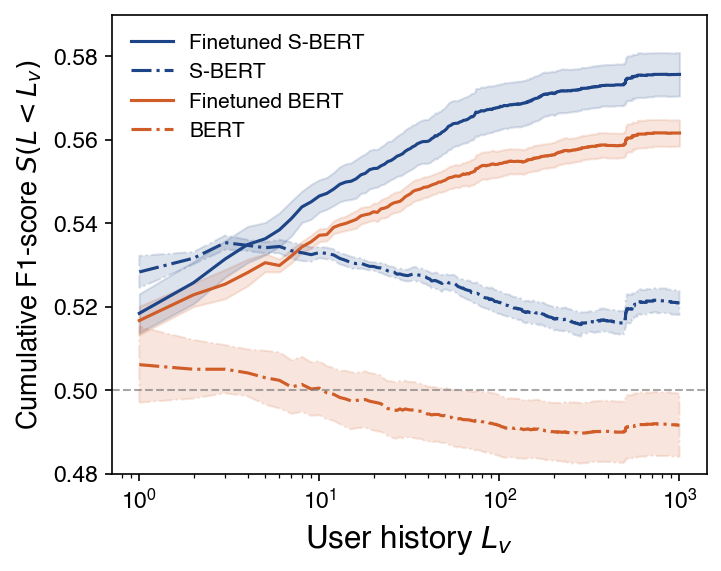

In [12]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['-','-','-.','-.']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    plt.plot(np.arange(1,1001), model2mat_f1[model_type].mean(axis=0), label='%s'%(model_labels[idx]), color=colors[idx], lw=1.5, ls=lstyle[idx])
    yerr = model2mat_f1[model_type].std(axis=0)/np.sqrt(5)
    plt.fill_between(np.arange(1,1001), y1 = model2mat_f1[model_type].mean(axis=0)+yerr,y2 = model2mat_f1[model_type].mean(axis=0)-yerr, color=colors[idx], alpha=0.15, ls=lstyle[idx])
    #plt.errorbar(np.arange(1,1001), model2mat_f1[model_type].mean(axis=0),yerr=yerr, color=colors[idx], alpha=0.3, lw=2, ls=lstyle[idx], label='%s'%(model_labels[idx]))

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Cumulative F1-score $S(L<L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
plt.axhline(0.5, ls='--', lw=1, color='gray', alpha=0.7, label='Random selection')
plt.ylim(0.48,0.59)  
  
plt.tight_layout()

## User history vs Accuracy

In [ ]:
model2mat_acc = {}

for model_type in model_types: 
        
    L = 1000
    mat_acc  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        print(model_type, data_idx)
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        
        for i in range(L):
            df_ = df_sample[df_sample['votelen']<=i+1]
            mat_acc[data_idx, i] = get_accuracy(df_['true_outcome'], df_['predicted_outcome'])
    
    
    model2mat_acc[model_type] = mat_acc

model_bert_ft 0
model_bert_ft 1
model_bert_ft 2


In [41]:
"""for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2acc_mat_%s'%(model_type), 'wb') as f:
        pickle.dump(model2mat_acc[model_type], f)"""

In [42]:
model2mat_acc = {}
for model_type in model_types:
    with open('../dataset/Downstream_result_vs_length/length2acc_mat_%s'%(model_type), 'rb') as f:
        model2mat_acc[model_type] = pickle.load(f)

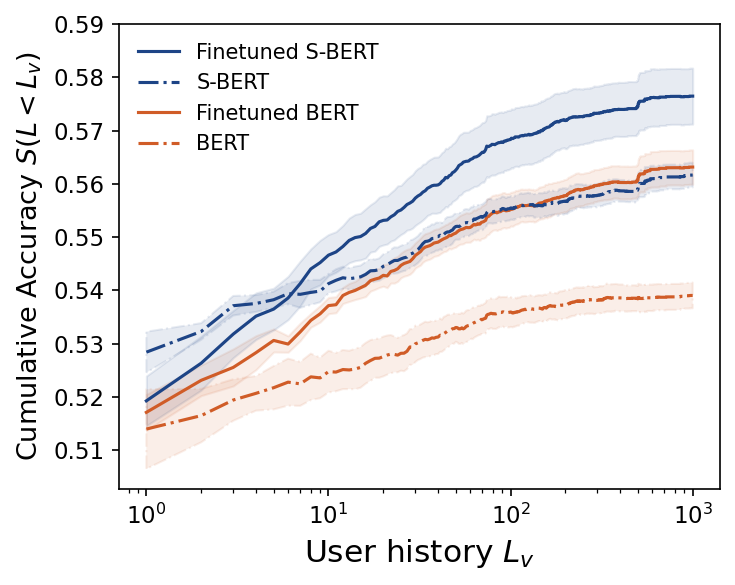

In [43]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['-','-','-.','-.']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    plt.plot(np.arange(1,1001), model2mat_acc[model_type].mean(axis=0), label='%s'%(model_labels[idx]), color=colors[idx], lw=1.5, ls=lstyle[idx])
    yerr = model2mat_acc[model_type].std(axis=0)/np.sqrt(5)
    plt.fill_between(np.arange(1,1001), y1 = model2mat_acc[model_type].mean(axis=0)+yerr,y2 = model2mat_acc[model_type].mean(axis=0)-yerr, color=colors[idx], alpha=0.1, ls=lstyle[idx])

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Cumulative Accuracy $S(L<L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
#plt.axhline(0.5, ls='--', lw=1.5, color='gray', alpha=0.7, label='Random selection')
plt.ylim(top=0.59)    
  
plt.tight_layout()

In [44]:
model2mat = {}

for model_type in model_types: 
        
    L = 11
    mat  = np.zeros((5,L))
    
    for data_idx in range(0,5):
        #print(model_type, data_idx)
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))
        ex = 2
        for i in range(L):
            df_ = df_sample[(ex**i<=df_sample['votelen']) & (df_sample['votelen']<ex**(i+1))]
            mat[data_idx, i] = get_f1_score(df_['true_outcome'], df_['predicted_outcome'])
            print(ex**i,'-' ,ex**(i+1), len(df_))
            
    model2mat[model_type] = mat

    print(model_type)
    print(mat)

1 - 2 2877
2 - 4 3590
4 - 8 3883
8 - 16 4512
16 - 32 4299
32 - 64 4629
64 - 128 3716
128 - 256 2971
256 - 512 1605
512 - 1024 691
1024 - 2048 435
1 - 2 3182
2 - 4 3786
4 - 8 4182
8 - 16 4887
16 - 32 4625
32 - 64 4964
64 - 128 3989
128 - 256 2816
256 - 512 1460
512 - 1024 842
1024 - 2048 438
1 - 2 2790
2 - 4 3464
4 - 8 4038
8 - 16 4739
16 - 32 4736
32 - 64 5419
64 - 128 4299
128 - 256 3612
256 - 512 1459
512 - 1024 1007
1024 - 2048 497
1 - 2 3038
2 - 4 3447
4 - 8 3372
8 - 16 3739
16 - 32 3479
32 - 64 3481
64 - 128 2975
128 - 256 2052
256 - 512 991
512 - 1024 663
1024 - 2048 496
1 - 2 2633
2 - 4 3211
4 - 8 3808
8 - 16 4325
16 - 32 4393
32 - 64 4838
64 - 128 4018
128 - 256 3297
256 - 512 1259
512 - 1024 840
1024 - 2048 385
model_bert_ft
[[0.52439845 0.54413562 0.53974474 0.55937422 0.58358015 0.57574374
  0.56120501 0.57545486 0.65504201 0.54352532 0.57577803]
 [0.50456572 0.527986   0.55212507 0.56713652 0.57527159 0.58450427
  0.59813441 0.59581296 0.62421586 0.6465396  0.57812574]
 [0.

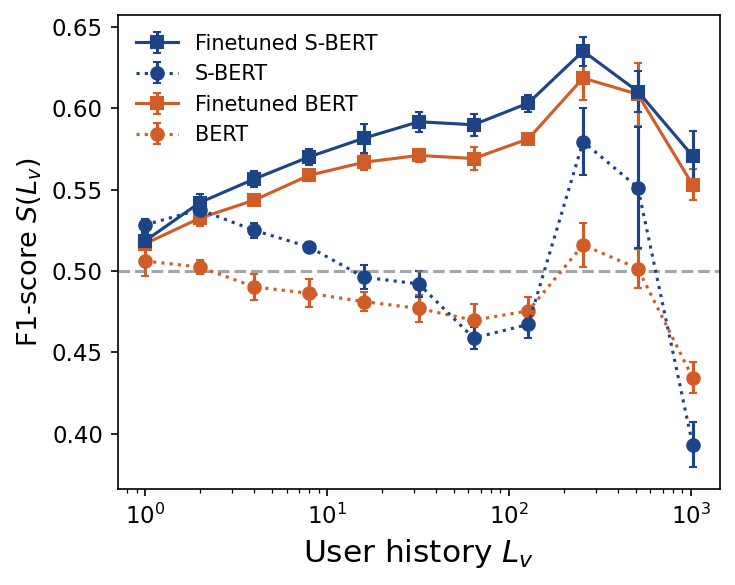

In [45]:
colors = ['#D05C27', '#1D4486', '#D05C27', '#1D4486']
lstyle = ['s-','s-','o:','o:']
fig, ax = plt.subplots(figsize=(5,4))

for idx, model_type in enumerate(model_types):
    x = [ex**l for l in range(L)]
    y = pd.DataFrame(model2mat[model_type]).mean()

    #plt.plot(x, y, color=colors[idx], lw=1.5, ls=lstyle[idx],  label='%s'%(model_labels[idx]))
    yerr = model2mat[model_type].std(axis=0)/np.sqrt(5)
    #plt.fill_between(x, y1 = y+yerr, y2=y-yerr, color=colors[idx], alpha=0.1, ls=lstyle[idx])
    plt.errorbar(x, y, yerr = yerr, color=colors[idx], fmt=lstyle[idx], capsize=2, label='%s'%(model_labels[idx]))

ax.tick_params(axis='both', labelsize=11)

#baseline
plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('F1-score $S(L_v)$', fontsize=13)
plt.xscale('log')

custom_order = [1, 3, 0, 2]  
handles, labels = plt.gca().get_legend_handles_labels()
reordered_handles = [handles[idx] for idx in custom_order]
reordered_labels = [labels[idx] for idx in custom_order]
plt.legend(reordered_handles, reordered_labels, frameon=False, fontsize=10, loc=2)

    
#baseline
#plt.ylim(top=0.59)    
plt.axhline(0.5, ls='--', lw=1.5, color='gray', alpha=0.7, label='Random selection')
  
plt.tight_layout()

## Length distribution

In [46]:
def logbinning(data, numbin=30):
    # log-scaled bins
    bins = np.logspace(0, np.log2(max(data)), num=numbin, base=2)
    widths = (bins[1:] - bins[:-1])

    # Calculate histogram
    hist = np.histogram(data, bins=bins)
    # normalize by bin width
    hist_norm = hist[0]/widths

    # plot it!
    x = bins[:-1]
    y = hist_norm
    
    return x, y, widths

In [47]:
Ls = []
for data_idx in range(5):
    
    result = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_types[0])) 
    
    df_g = result.groupby('username')
      
    votelengths = []
    for g, df_ in df_g:
        votelengths.append(df_['votelen'].iloc[0])
        
    Ls.append(votelengths)

/tmp/ipykernel_1061777/3446611558.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_map = plt.cm.get_cmap('Blues')


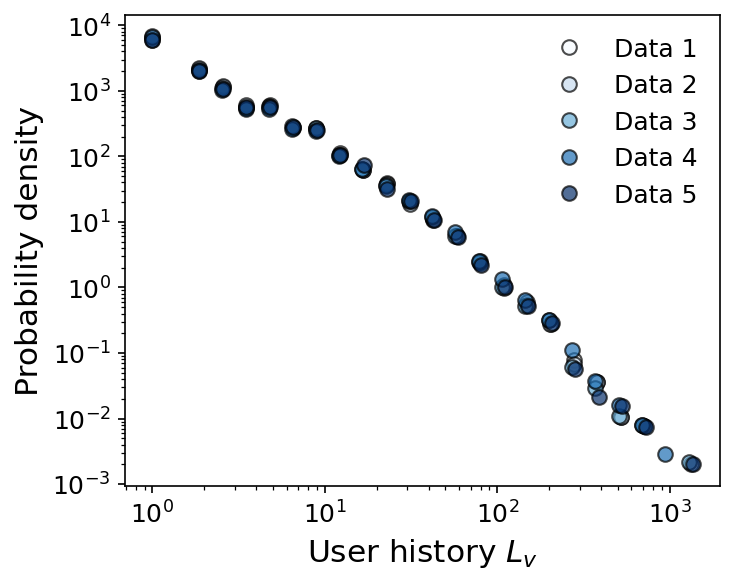

In [48]:
#colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

viridis_map = plt.cm.get_cmap('Blues')
color_values = np.linspace(0, 1, 5)
cmap = [viridis_map(color_val) for color_val in color_values]

plt.figure(figsize=(5,4))

for i in range(len(Ls)):
    x, y, widths = logbinning(Ls[i], numbin=25)
    plt.loglog(x, y, 'o', ms=7, alpha=0.7, markeredgecolor='k', c=cmap[i],  label='Data %d'%(i+1))

plt.xlabel(r'User history $L_v$', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
#plt.savefig('../fig/vote_length_distribution(5fold_data).pdf', transparent=True)
plt.show()

In [ ]:
model2acc = {}
print("prediction accuracy")
for model_type in ['model_roberta-base_ft']:    
    model2acc[model_type] = []
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))

        y = df_sample['true_outcome']
        y_hat = df_sample['predicted_outcome']
        print("%.4f"%get_accuracy(y, y_hat))

In [68]:
model2acc = {}
print("prediction accuracy")
for model_type in ['model_bert']:    
    model2acc[model_type] = []
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))

        y = df_sample['true_outcome']
        y_hat = df_sample['predicted_outcome']
        print("%.4f"%get_accuracy(y, y_hat))

prediction accuracy
0.5463
0.5362
0.5418
0.5333
0.5352


In [69]:
model2acc = {}
print("prediction accuracy")
for model_type in ['model_bert_ft']:    
    model2acc[model_type] = []
    for data_idx in range(0,5):
        df_sample = pd.read_pickle("../dataset/DownstreamTask_Dataframe/downstream_results_data(%d)_model(%s).p"%(data_idx, model_type))

        y = df_sample['true_outcome']
        y_hat = df_sample['predicted_outcome']
        print("%.4f"%get_accuracy(y, y_hat))

prediction accuracy
0.5678
0.5716
0.5614
0.5514
0.5629
